### Goals
In this notebook, you're going to implement a U-Net for a biomedical imaging segmentation task. Specifically, you're going to be labeling neurons, so one might call this a neural neural network! ;) 

Note that this is not a GAN, generative model, or unsupervised learning task. This is a supervised learning task, so there's only one correct answer (like a classifier!) You will see how this component underlies the Generator component of Pix2Pix in the next notebook this week.

### Learning Objectives
1.   Implement your own U-Net.
2.   Observe your U-Net's performance on a challenging segmentation task.


In [1]:
import sys, torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
sys.path.append("..")

from models.Pix2Pix.unet import ContractingBlock, ExpandingBlock, UpsamplingBlock, UNet
from models.vis_utils import show_img_batch
from models.utils import weights_init
%matplotlib inline

device = "mps" if torch.backends.mps.is_available() else "cpu"

In [2]:
hidden_size        = 32
sample             = torch.randn(10, 3, 512, 512)

### Contracting network
print("--------------- Contracting network ---------------")
contracting_block1 = ContractingBlock(3,                hidden_size)
contracting_block2 = ContractingBlock(hidden_size * 1,  hidden_size * 2, use_dropout=True)
contracting_block3 = ContractingBlock(hidden_size * 2,  hidden_size * 4, use_dropout=True)
contracting_block4 = ContractingBlock(hidden_size * 4,  hidden_size * 8, use_dropout=True)
contracting_block5 = ContractingBlock(hidden_size * 8,  hidden_size * 16)
contracting_block6 = ContractingBlock(hidden_size * 16, hidden_size * 32)

cb1  = contracting_block1(sample)
print("cb1  shape: ", cb1.shape) 
cb1_ = nn.MaxPool2d(kernel_size=2, stride=2)(cb1)
print("cb1_ shape: ", cb1_.shape) 
cb2 = contracting_block2(cb1_)
print("cb2  shape: ", cb2.shape) 
cb2_ = nn.MaxPool2d(kernel_size=2, stride=2)(cb2)
print("cb2_ shape: ", cb2_.shape) 
cb3 = contracting_block3(cb2_)
print("cb3  shape: ", cb3.shape)
cb3_ = nn.MaxPool2d(kernel_size=2, stride=2)(cb3)
print("cb3_ shape: ", cb3_.shape)
cb4 = contracting_block4(cb3_)
print("cb4  shape: ", cb4.shape)
cb4_ = nn.MaxPool2d(kernel_size=2, stride=2)(cb4)
print("cb4_ shape: ", cb4_.shape)
cb5 = contracting_block5(cb4_)
print("cb5  shape: ", cb5.shape)
cb5_ = nn.MaxPool2d(kernel_size=2, stride=2)(cb5)
print("cb5_ shape: ", cb5_.shape)
cb6 = contracting_block6(cb5_)
print("cb6  shape: ", cb6.shape)

### Expanding network
print("---------------- Expanding network ----------------")
expanding_block5 = ExpandingBlock(hidden_size * 32, hidden_size * 16)
expanding_block4 = ExpandingBlock(hidden_size * 16, hidden_size * 8)
expanding_block3 = ExpandingBlock(hidden_size * 8,  hidden_size * 4)
expanding_block2 = ExpandingBlock(hidden_size * 4,  hidden_size * 2)
expanding_block1 = ExpandingBlock(hidden_size * 2,  hidden_size * 1)

        
upsampling_block5 = UpsamplingBlock(hidden_size * 32, hidden_size * 16)
upsampling_block4 = UpsamplingBlock(hidden_size * 16, hidden_size * 8)
upsampling_block3 = UpsamplingBlock(hidden_size * 8,  hidden_size * 4)
upsampling_block2 = UpsamplingBlock(hidden_size * 4,  hidden_size * 2)
upsampling_block1 = UpsamplingBlock(hidden_size * 2,  hidden_size * 1)
        
eb6_ = upsampling_block5(cb6)
print("eb6_ shape: ", eb6_.shape) 
eb5  = expanding_block5(eb6_, cb5)
print("eb5  shape: ", eb5.shape) 
eb5_ = upsampling_block4(eb5)
print("eb5_ shape: ", eb5_.shape) 
eb4  = expanding_block4(eb5_, cb4)
print("eb4  shape: ", eb4.shape) 
eb4_ = upsampling_block3(eb4)
print("eb4_ shape: ", eb4_.shape) 
eb3  = expanding_block3(eb4_, cb3)
print("eb3  shape: ", eb3.shape) 
eb3_ = upsampling_block2(eb3)
print("eb3_ shape: ", eb3_.shape) 
eb2  = expanding_block2(eb3_, cb2)
print("eb2  shape: ", eb2.shape) 
eb2_ = upsampling_block1(eb2)
print("eb2_ shape: ", eb2_.shape) 
eb1 = nn.Conv2d(hidden_size, 3, kernel_size=1)(eb2_)
print("eb0 shape: ", eb1.shape)

--------------- Contracting network ---------------
cb1  shape:  torch.Size([10, 32, 512, 512])
cb1_ shape:  torch.Size([10, 32, 256, 256])
cb2  shape:  torch.Size([10, 64, 256, 256])
cb2_ shape:  torch.Size([10, 64, 128, 128])
cb3  shape:  torch.Size([10, 128, 128, 128])
cb3_ shape:  torch.Size([10, 128, 64, 64])
cb4  shape:  torch.Size([10, 256, 64, 64])
cb4_ shape:  torch.Size([10, 256, 32, 32])
cb5  shape:  torch.Size([10, 512, 32, 32])
cb5_ shape:  torch.Size([10, 512, 16, 16])
cb6  shape:  torch.Size([10, 1024, 16, 16])
---------------- Expanding network ----------------
eb6_ shape:  torch.Size([10, 512, 32, 32])
eb5  shape:  torch.Size([10, 512, 32, 32])
eb5_ shape:  torch.Size([10, 256, 64, 64])
eb4  shape:  torch.Size([10, 256, 64, 64])
eb4_ shape:  torch.Size([10, 128, 128, 128])
eb3  shape:  torch.Size([10, 128, 128, 128])
eb3_ shape:  torch.Size([10, 64, 256, 256])
eb2  shape:  torch.Size([10, 64, 256, 256])
eb2_ shape:  torch.Size([10, 32, 512, 512])
eb0 shape:  torch.Size

In [4]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Structured like the contracting path of the U-Net, the discriminator will
    output a matrix of values classifying corresponding portions of the image as real or fake. 
    Parameters:
        input_channels: the number of image input channels
        hidden_channels: the initial number of discriminator convolutional filters
    '''
    def __init__(self, input_channels, hidden_channels=8):
        super().__init__()
        self.contract1 = ContractingBlock(input_channels,      hidden_channels * 1)
        self.contract2 = ContractingBlock(hidden_channels * 1, hidden_channels * 2, use_bn=False)
        self.contract3 = ContractingBlock(hidden_channels * 2, hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 4, hidden_channels * 8)
        self.contract5 = ContractingBlock(hidden_channels * 8, hidden_channels * 16)
        self.final     = nn.Conv2d(hidden_channels * 16, 1, kernel_size=1)

    def forward(self, x, y):
        x0 = torch.cat([x, y], axis=1)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x2_ = nn.MaxPool2d(kernel_size=2, stride=2)(x2)
        x3 = self.contract3(x2_)
        x3_ = nn.MaxPool2d(kernel_size=2, stride=2)(x3)
        x4 = self.contract4(x3_)
        x4_ = nn.MaxPool2d(kernel_size=2, stride=2)(x4)
        x5 = self.contract5(x4_)
        x5_ = nn.MaxPool2d(kernel_size=2, stride=2)(x5)
        xn = self.final(x5_)
        return xn

In [ ]:
sample = torch.randn(10, 3, 512, 512)
unet = UNet(3,3,32)
u_sample = unet(sample)
print(f"Input shape is {sample.shape} | Output shape is {u_sample.shape}")

In [ ]:
disc = Discriminator(6)
disc(sample, sample).shape

## Load the data

In [7]:
from torchvision import transforms
from torchvision.datasets import ImageFolder

batch_size = 4

In [9]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = ImageFolder("../datasets/maps", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
img_batch,_ = next(iter(dataloader))
width = img_batch.shape[-1]
real = img_batch[:, :, :, :width//2]
cond = img_batch[:, :, :, width//2:]
show_img_batch(real, size=(3,600, 600))
show_img_batch(cond, size=(3,600, 600))

## Training a Pix2Pix model

In [14]:

bce = nn.BCEWithLogitsLoss() 
l1loss = nn.L1Loss() 
lambda_recon = 200

n_epochs = 50
input_dim = 3
real_dim = 3
hidden_size = 32 
display_step = 200
lr = 0.0002
target_shape = 256
device = 'mps'

In [15]:
gen = UNet(input_dim, real_dim, hidden_size).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(input_dim + real_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [ ]:
cur_step = 0
generator_losses = []
discriminator_losses = []

for epoch in range(n_epochs):
    for img_batch, _ in tqdm(dataloader):
        

        img_width = img_batch.shape[-1]
        cond = img_batch[:, :, :, :img_width//2]
        cond = nn.functional.interpolate(cond, size=target_shape)
        cond = cond.to(device)

        real = img_batch[:, :, :, img_width//2:]
        real = nn.functional.interpolate(real, size=target_shape)
        real = real.to(device)
        
        # Train discriminator
        disc_opt.zero_grad()
        with torch.no_grad():
            fake = gen(cond)
        disc_fake = disc(fake.detach(), cond)
        disc_fake_loss = bce(disc_fake, torch.zeros_like(disc_fake, device=device)) 

        disc_real = disc(real, cond)
        disc_real_loss = bce(disc_real, torch.ones_like(disc_real, device=device))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        discriminator_losses.append(disc_loss.item())

        # Train generator
        gen_opt.zero_grad()
        fake = gen(cond)
        gen_fake = disc(fake, cond)
        gen_loss = bce(gen_fake, torch.ones_like(disc_real, device=device)) + lambda_recon*l1loss(fake, real)
        # gen_loss = get_gen_loss(gen, disc, real, cond, bce, l1loss, lambda_recon)
        gen_loss.backward()
        gen_opt.step()


        generator_losses.append(gen_loss.item())

        if cur_step % display_step == 0:
            mean_generator_loss = sum(generator_losses[-display_step:]) / display_step
            mean_discriminator_loss = sum(discriminator_losses[-display_step:]) / display_step
            if cur_step > 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
            else:
                print("Pretrained initial state")
            show_img_batch(cond, size=(input_dim, target_shape, target_shape))
            show_img_batch(real, size=(real_dim, target_shape, target_shape))
            show_img_batch(fake, size=(real_dim, target_shape, target_shape))
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


Epoch 49: Step 27450: Generator (U-Net) loss: 10.606203117370605, Discriminator loss: 0.16631442222278564


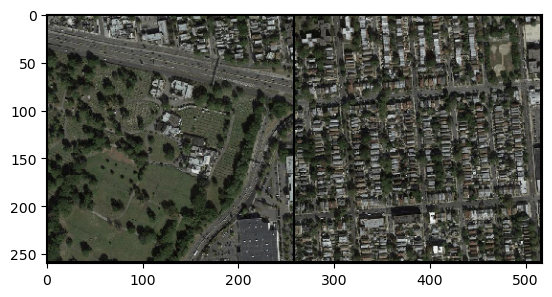

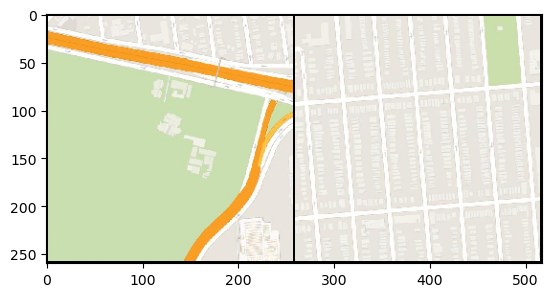

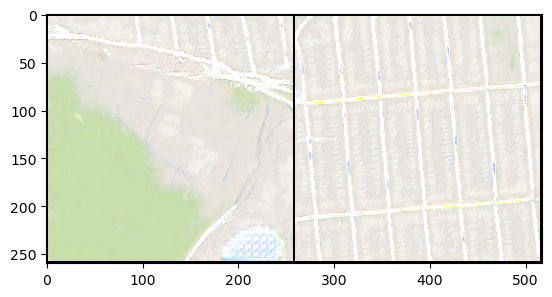

In [20]:
mean_generator_loss = sum(generator_losses[-display_step:]) / display_step
mean_discriminator_loss = sum(discriminator_losses[-display_step:]) / display_step
print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
show_img_batch(cond, size=(input_dim, target_shape, target_shape))
show_img_batch(real, size=(real_dim, target_shape, target_shape))
show_img_batch(fake, size=(real_dim, target_shape, target_shape))